# Compressing Word Embeddings

This notebook compares the performance of different lossy compression methods for Bayesian word embeddings.
The quality of compressed word embeddings is measured using the the "semantic and syntactic reasoning task" proposed in [Mikolov et al., ICLR 2013](https://arxiv.org/abs/1301.3781).

In [1]:
import numpy as np
import tensorflow as tf
import scipy
from collections import Counter
import io
import gzip
import bz2
import lzma

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

In [3]:
from matplotlib.ticker import AutoMinorLocator

## Load Vocabulary

In [3]:
with open('/path/to/vocab_1980to2008_vocabsize100000_unweighted.tsv') as file:
    assert file.readline().split('\t')[0] == "WORD"
    vocab = [line.split('\t')[0] for line in file.readlines()]
print('Vocabulary size: %d ("%s", "%s", ..., "%s", "%s")' % (len(vocab), vocab[0], vocab[1], vocab[-2], vocab[-1]))

Vocabulary size: 100000 (",", "the", ..., "Titmuss", "143-45")


In [4]:
inverse_vocab = {word: index for index, word in enumerate(vocab)}

## Load Semantic & Syntactic Reasining Tasks

File `questions-words.txt` downloaded from [this word2vec repo on Github](https://raw.githubusercontent.com/nicholas-leonard/word2vec/master/questions-words.txt).

In [5]:
with open('questions-words.txt') as file:
    analogies_str = [
        line.rstrip().split(' ')
        for line in file.readlines()
        if line[0] != ':'
    ]

In [6]:
analogies_id = []
for line in analogies_str:
    ok = True
    current = []
    for word in line:
        try:
            current.append(inverse_vocab[word])
        except:
            ok = False
            break
    if ok:
        analogies_id.append(current)
        
analogies_id = np.array(analogies_id)

In [7]:
len(analogies_str), len(analogies_id), len(analogies_id) / len(analogies_str)

(19544, 16649, 0.85187269750307)

## Load Word Embeddings From Tensorflow Checkpoint

In [8]:
reader = tf.train.NewCheckpointReader(
    '/path/to/trained/checkpoint-100000')
print(reader.debug_string().decode('utf-8'))
vecs_u = reader.get_tensor('q/mean_u')
stds_u = np.exp(reader.get_tensor('q/log_std_u'))

q/log_std_u (DT_FLOAT) [100000,100]
q/log_std_v (DT_FLOAT) [100000,100]
q/mean_u (DT_FLOAT) [100000,100]
q/mean_v (DT_FLOAT) [100000,100]
step (DT_INT32) []



## Evaluate Performance of Uncompressed Word Embeddings

In [9]:
def prediction_ranks(emb):
    normed = emb / (1e-8 + np.sqrt(np.sum(emb**2, axis=1, keepdims=True)))
    predicted_vecs = (
        normed[analogies_id[:, 1], :]
        - normed[analogies_id[:, 0], :]
        + normed[analogies_id[:, 2], :])       # shape (N, K)
    predicted_scores = predicted_vecs.dot(normed.T)  # shape (N, V)
    num_tests, vocab_size = predicted_scores.shape
    gt_scores = predicted_scores.ravel()[
        np.arange(0, num_tests*vocab_size, vocab_size) + analogies_id[:, 3]]
    return vocab_size - np.sum(predicted_scores < gt_scores[:, np.newaxis], axis=1) - 1

In [10]:
predicted_ranks = prediction_ranks(vecs_u)

In [11]:
full_h10 = np.sum(predicted_ranks < 10) / len(analogies_id)

In [12]:
np.sum(predicted_ranks < 1) / len(analogies_id)

0.15075980539371733

In [13]:
mrr = np.average(1 / (1 + predicted_ranks))
mrr

0.302256731104162

## Compression with Empirical Gaussian Prior

In [14]:
def normal_pdf(mean, std, x):
    return 1 / (np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((x - mean) / std)**2)

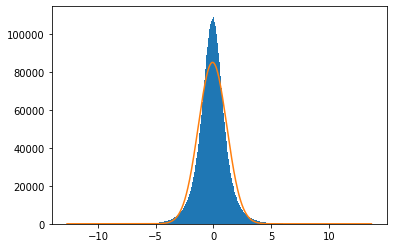

In [15]:
plt.figure()
_, xs, _ = plt.hist(vecs_u.ravel(), bins=1000);
scale = len(vecs_u.ravel()) * (xs[-1] - xs[0]) / len(xs)
plt.plot(xs, scale * normal_pdf(
    vecs_u.ravel().mean(), vecs_u.ravel().std(), xs));
# plt.yscale('log')

Not really a great fit but let's try it anyway.

In [16]:
vecs_u.ravel().mean(), vecs_u.ravel().std()

(-0.07991123, 1.2329023)

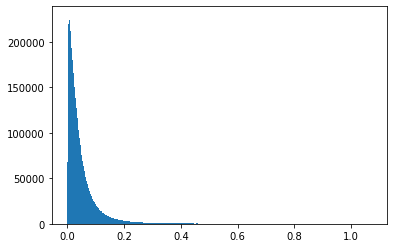

In [17]:
plt.figure()
plt.hist(stds_u.ravel(), bins=1000);

In [18]:
empirical_mean = 0
empirical_std = np.sqrt(np.mean(vecs_u.ravel()**2))

In [19]:
max_codepoint_length = 10
codepoints_and_lengths = [
    (scipy.stats.norm.ppf(codepoint_xi, scale=empirical_std), length)
    for length in range(max_codepoint_length+1)
    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
]
codepoints = np.array([codepoint for codepoint, _ in codepoints_and_lengths])
lengths = np.array([length for _, length in codepoints_and_lengths])

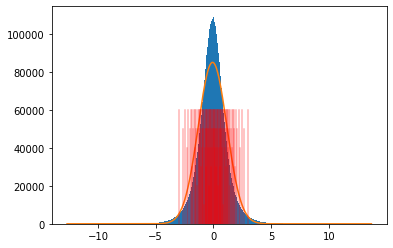

In [20]:
plt.figure()
_, xs, _ = plt.hist(vecs_u.ravel(), bins=1000);
scale = len(vecs_u.ravel()) * (xs[-1] - xs[0]) / len(xs)
plt.plot(xs, scale * normal_pdf(
    vecs_u.ravel().mean(), vecs_u.ravel().std(), xs))
for codepoint, length in codepoints_and_lengths:
    if length > 6:
        break
    plt.plot((codepoint, codepoint), (0, 10000*length), c='r', alpha=0.3)

In [21]:
def compress_coordinates(means, stds, beta, bitlengths=lengths):
    # N = len(means.ravel()) = len(stds.ravel())
    # C = len(codepoints)
    optima = np.empty_like(means)
    for i in range(0, 10000000, 100000):
        if i % 1000000 == 0:
            print(i / 10000000)
        squared_errors = (codepoints[np.newaxis, :] - means.ravel()[i:i+100000, np.newaxis])**2
            # shape (N, C)
        weighted_penalties = (2 * beta) * stds.ravel()[i:i+100000, np.newaxis]**2 * bitlengths[np.newaxis, :]
            # shape (N, C)
        optima_idxs = np.argmin(squared_errors + weighted_penalties, axis=1)
        optima.ravel()[i:i+100000] = codepoints[optima_idxs]
#     optima_lengths = bitlengths[optima_idxs].reshape(means.shape)
    return optima, None # optima_lengths

In [23]:
def empirical_entropy(values):
    counts = np.array(list(Counter(values.ravel()).values()))
    total_counts = counts.sum()
    return total_counts * np.log2(total_counts) - counts.dot(np.log2(counts))

In [24]:
def test_beta(means, stds, beta):
    print('compressing with beta=%g ...' % beta)
    compressed = compress_coordinates(means, stds, beta)
    print('getting prediction ranks ...')
    ranks = prediction_ranks(compressed)
    mrr = np.average(1 / (1 + ranks))
    acc = np.sum(ranks == 0) / len(ranks)
    hits10 = np.sum(ranks < 10) / len(ranks)
    compressed_bitlength = empirical_entropy(compressed)
    return mrr, acc, hits10, compressed_bitlength

### Do the actual compression

**Note:** this is ridiculously inefficient because it doesn't actually use the fast optimization algorithm shown in the paper but instead a very naive algorithm that produces the exact same result but is much slower because it literally tries out all code points up to rate $\mathcal R_\text{max}$. But it was easier to implement like this.

The code for image compression experiments contains an actual implementation of Algorithm 1 of the paper.

In [83]:
betas = np.exp(np.linspace(np.log(0.01), np.log(100000), 50))
mrrs_and_bitlengths = np.array([test_beta(vecs_u, stds_u, beta) for beta in betas])

compressing with beta=0.01 ...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
getting prediction ranks ...
compressing with beta=0.013895 ...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
getting prediction ranks ...
compressing with beta=0.019307 ...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
getting prediction ranks ...
compressing with beta=0.026827 ...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
getting prediction ranks ...
compressing with beta=0.0372759 ...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
getting prediction ranks ...
compressing with beta=0.0517947 ...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
getting prediction ranks ...
compressing with beta=0.0719686 ...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
getting prediction ranks ...
compressing with beta=0.1 ...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
getting prediction ranks ...
compressing with beta=0.13895 ...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
getting prediction ranks ...
compressing with beta=0.19307 ...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0

## Save results to a file

In [84]:
# import shelve
# s = shelve.open('compression-results.shelve')
# s['mrrs_and_bitlengths'] = mrrs_and_bitlengths
# s.close()

## Baseline (quantize to equidistant grid, then entropy code)

In [85]:
def quantize_coordinates(means, quantization_max):
    scale = (quantization_max + 0.5) / np.abs(means).max()
    quantized_scaled = np.round(np.clip(
        scale * means, -quantization_max, quantization_max))
    return quantized_scaled

In [86]:
def test_quantization(means, quantization_max):
    print('quantization_max=%d' % quantization_max)
    quantized = quantize_coordinates(means, quantization_max)

    print('  Getting ranks ...')
    ranks = prediction_ranks(quantized)
    mrr = np.average(1 / (1 + ranks))
    acc = np.sum(ranks == 0) / len(ranks)
    hits10 = np.sum(ranks < 10) / len(ranks)

    print('  Getting entropy ...')
    compressed_bitlength = empirical_entropy(quantized)

    print('  Converting to bytes ...')
    if quantization_max <= 127:
        quantized_bytes = quantized.astype(np.int8)
    else:
        quantized_bytes = quantized.astype(np.int16)

    print('  Gzipping ...')
    buf = io.BytesIO()
    gz = gzip.GzipFile(fileobj=buf, mode="wb", compresslevel=9)
    gz.write(bytes(quantized_bytes.data))
    gz.flush()
    gz.close()
    buf.flush()
    gzip_bitlength = len(buf.getbuffer()) * 8

    print('  Bzip2 ...')
    buf = io.BytesIO()
    bz = bz2.BZ2File(buf, mode="wb", compresslevel=9)
    bz.write(bytes(quantized_bytes.data))
    bz.flush()
    bz.close()
    buf.flush()
    bz2_bitlength = len(buf.getbuffer()) * 8

    print('  Lzma ...')
    buf = io.BytesIO()
    lz = lzma.LZMAFile(buf, mode="wb", preset=9, format=lzma.FORMAT_ALONE)
    lz.write(bytes(quantized_bytes.data))
    lz.flush()
    lz.close()
    buf.flush()
    lzma_bitlength = len(buf.getbuffer()) * 8

    print('  entropy        = %d' % compressed_bitlength)
    print('  gzip_bitlength = %d' % gzip_bitlength)
    print('  bz2_bitlength  = %d' % bz2_bitlength)
    print('  lzma_bitlength = %d' % lzma_bitlength)

    return mrr, acc, hits10, compressed_bitlength, gzip_bitlength, bz2_bitlength, lzma_bitlength

In [87]:
# quantizations = [1023, 511, 255, 127, 63, 31, 15, 7, 3, 2, 1]
quantizations = list(range(1, 10)) + [int(round(i)) for i in np.exp(np.linspace(np.log(10), np.log(1023), 50))]
mrrs_and_bitlengths_baseline = np.array([
    test_quantization(vecs_u, q) for q in quantizations])

quantization_max=1
  Getting ranks ...
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 487552
  gzip_bitlength = 658464
  bz2_bitlength  = 374936
  lzma_bitlength = 684184
quantization_max=2
  Getting ranks ...
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 2858929
  gzip_bitlength = 3351280
  bz2_bitlength  = 2444584
  lzma_bitlength = 2846608
quantization_max=3
  Getting ranks ...
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 5867679
  gzip_bitlength = 6819032
  bz2_bitlength  = 5634088
  lzma_bitlength = 5498480
quantization_max=4
  Getting ranks ...
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 8756431
  gzip_bitlength = 10241784
  bz2_bitlength  = 9020728
  lzma_bitlength = 8184248
quantization_max=5
  Getting ranks ...
  Getting entropy ...
  Converti

  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 53888912
  gzip_bitlength = 56250232
  bz2_bitlength  = 56904880
  lzma_bitlength = 54351304
quantization_max=128
  Getting ranks ...
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 55178744
  gzip_bitlength = 73381480
  bz2_bitlength  = 60619152
  lzma_bitlength = 60442744
quantization_max=141
  Getting ranks ...
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 56567802
  gzip_bitlength = 75189848
  bz2_bitlength  = 62006688
  lzma_bitlength = 61997632
quantization_max=155
  Getting ranks ...
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 57928318
  gzip_bitlength = 76939216
  bz2_bitlength  = 63385056
  lzma_bitlength = 63520472
quantization_max=170
  Getting ranks ...
  Getting entropy ...
  Converting to bytes 

## Save results to a file

In [88]:
# import shelve
# s = shelve.open('compression-results.shelve')
# s['mrrs_and_bitlengths_baseline'] = mrrs_and_bitlengths_baseline
# s.close()

# Plot Results

## Load results from file

Only necessary if the experiments weren't carried out in this session.

In [5]:
import shelve
s = shelve.open('compression-results.shelve')
mrrs_and_bitlengths_baseline = s['mrrs_and_bitlengths_baseline']
mrrs_and_bitlengths = s['mrrs_and_bitlengths']
s.close()

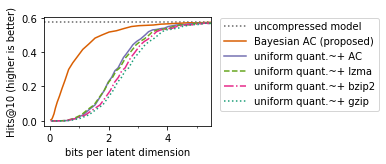

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
num_dimensions = 10000000
full_h10 = 0.5743287885158268
ax.axhline(full_h10, linestyle=':', color='#666666', label='uncompressed model')


ax.plot(
    mrrs_and_bitlengths[:, -1] / num_dimensions,
    mrrs_and_bitlengths[:, 2],
    '-', label='Bayesian AC (proposed)', c='#d95f02')

ax.plot(
    mrrs_and_bitlengths_baseline[:, -4] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 2],
    '-', label='uniform quant.~+ AC', c='#7570b3')



ax.plot(
    mrrs_and_bitlengths_baseline[:, -1] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 2],
    '--', label='uniform quant.~+ lzma',  c='#66a61e')

ax.plot(
    mrrs_and_bitlengths_baseline[:, -2] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 2],
    '-.', label='uniform quant.~+ bzip2',  c='#e7298a')

ax.plot(
    mrrs_and_bitlengths_baseline[:, -3] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 2],
     ':', label='uniform quant.~+ gzip', c='#1b9e77')

ax.xaxis.set_minor_locator(AutoMinorLocator(2))

ax.set_xlabel('bits per latent dimension')
ax.set_xlim(-0.2, 5.5)

plt.xlabel('bits per latent dimension')
ax.set_ylabel('Hits@10 (higher is better)')
lgd = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.04), labelspacing=0.5, handlelength=2.2)
fig.subplots_adjust(wspace=0.35)

In [ ]:
fig.savefig('word-embeddings-uncropped.pdf', bbox_inches='tight', pad_inches=20)
!pdfcrop word-embeddings-uncropped.pdf word-embeddings.pdf && rm word-embeddings-uncropped.pdf